In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import pywt
from scipy.ndimage import median_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# Load Dataset
The Real Doppler RAD-DAR dataset contains over 17,000 FMCW radar samples of drones, cars, and people, formatted as 11 x 61 CFAR-processed range-Doppler matrices. It supports research in radar-based object classification by providing labeled spectrograms for machine learning applications

In [2]:
# Define dataset path
dataset_path = "/kaggle/input"

categories = {"Cars": 0, "Drones": 1, "People": 2}

# Initialize 
X = []  # Features (Radar Matrices)
y = []  # Labels

# Iterate through each category folder
for category, label in categories.items():
    category_path = os.path.join(dataset_path, category)

    for root, _, files in os.walk(category_path):
        for file in files:
            if file.endswith(".csv"):  # Ensure it's a CSV file
                file_path = os.path.join(root, file)

                try:
                    # Read CSV and convert to NumPy array
                    df = pd.read_csv(file_path, header=None).values
                    X.append(df)  # Store radar matrix
                    y.append(label)  # Store corresponding label

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

X = np.array(X)  # Shape: (num_samples, 11, 61)
y = np.array(y)  # Shape: (num_samples,)

# Print dataset summary
print(f"Loaded {len(X)} radar samples")
print(f"Class Distribution: Cars={sum(y==0)}, Drones={sum(y==1)}, People={sum(y==2)}")

Loaded 17485 radar samples
Class Distribution: Cars=5720, Drones=5065, People=6700


# Plot a Sample Data

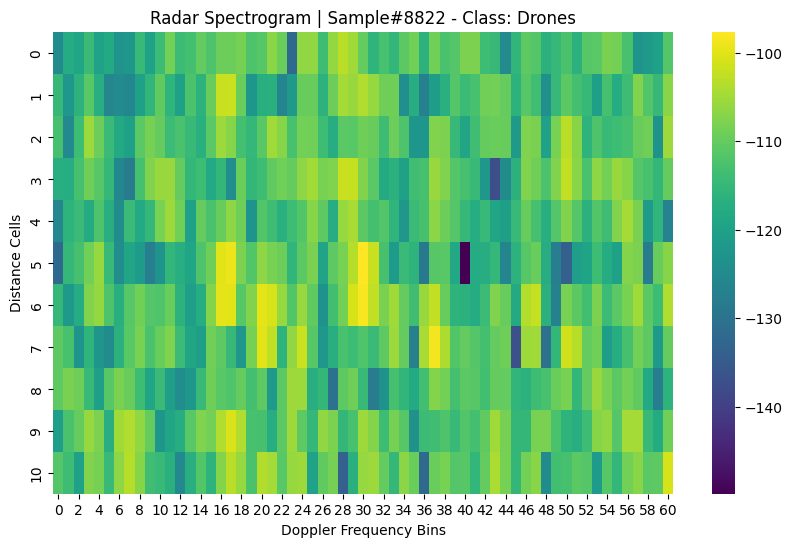

In [3]:
# Select a random radar sample
sample_index = np.random.randint(0, len(X))
radar_matrix = X[sample_index]
sample_label = y[sample_index]

label_map = {0: 'Car',1: 'Drones',2: 'People'}
category_name = label_map[sample_label] 

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(radar_matrix, cmap="viridis", cbar=True)
plt.title(f"Radar Spectrogram | Sample#{sample_index} - Class: {category_name}")
plt.xlabel("Doppler Frequency Bins")
plt.ylabel("Distance Cells")
plt.show()


# Preprocessing Function
## Applies wavelet denoising, median filtering, normalization, and cropping to radar spectrograms for noise reduction.

Note: Initially, I explored conventional methods such as Gaussian filters and Wiener filters for denoising radar spectrograms. While Gaussian filtering provided basic smoothing, it also blurred important micro-Doppler patterns critical for accurate classification.

Wavelet denoising, specifically using Daubechies wavelets, showed better performance by preserving fine radar signatures while reducing noise. Additionally, combining wavelet denoising with a median filter helped eliminate isolated speckle noise without distorting target reflections.

This approach improved classification accuracy compared to traditional denoising techniques, making it the most effective choice for our radar-based ML pipeline

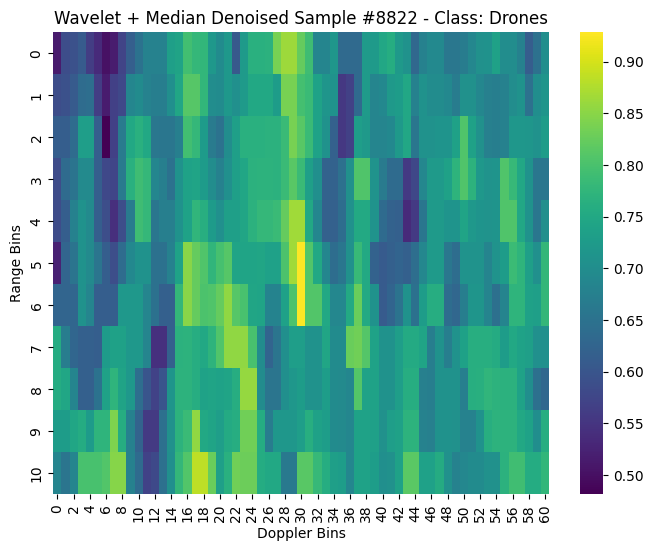

In [4]:
import pywt
from scipy.ndimage import median_filter

def wavelet_median_denoise(matrix, wavelet='db4', level=1, verbose=True):
    # Wavelet Denoising
    coeffs = pywt.wavedec2(matrix, wavelet=wavelet, level=level)
    coeffs_thresh = []
    
    for c in coeffs:
        if isinstance(c, tuple):
            cH, cV, cD = c
            cH = pywt.threshold(cH, value=0.1 * np.max(cH), mode='soft')
            cV = pywt.threshold(cV, value=0.1 * np.max(cV), mode='soft')
            cD = pywt.threshold(cD, value=0.1 * np.max(cD), mode='soft')
            coeffs_thresh.append((cH, cV, cD))
        else:
            cA = pywt.threshold(c, value=0.1 * np.max(c), mode='soft')
            coeffs_thresh.append(cA)
    
    wavelet_denoised = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
    
    # Min-Max Normalization
    wavelet_denoised = (wavelet_denoised - np.min(wavelet_denoised)) / (np.max(wavelet_denoised) - np.min(wavelet_denoised) + 1e-6)
    
    # Median Filtering
    median_denoised = median_filter(wavelet_denoised, size=(3, 3))
    
    #Crop to original radar matrix size (11 x 61)
    denoised_cropped = median_denoised[:11, :61]
    return denoised_cropped

denoised = wavelet_median_denoise(radar_matrix)

# Plot result
plt.figure(figsize=(8, 6))
sns.heatmap(denoised, cmap="viridis")
plt.title(f"Wavelet + Median Denoised Sample #{sample_index} - Class: {category_name}")
plt.xlabel("Doppler Bins")
plt.ylabel("Range Bins")
plt.show()

# Training the Model - Random Forest Classifier

### RF handles noisy, high-dimensional radar data well, reduces overfitting, and provides feature importance for model interpretability.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Apply denoise + flatten to all matrices
X_denoised_flattened = []
for matrix in X:
    denoised = wavelet_median_denoise(matrix)
    X_denoised_flattened.append(denoised.flatten())

X_denoised_flattened = np.array(X_denoised_flattened)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_denoised_flattened, y, test_size=0.2, random_state=42, stratify=y)

# 3. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# 4. Evaluate
y_pred = rf.predict(X_test)

# Feature Importance

Feature importance highlights key Doppler-range bins influencing classification, improving model transparency and decision understanding.

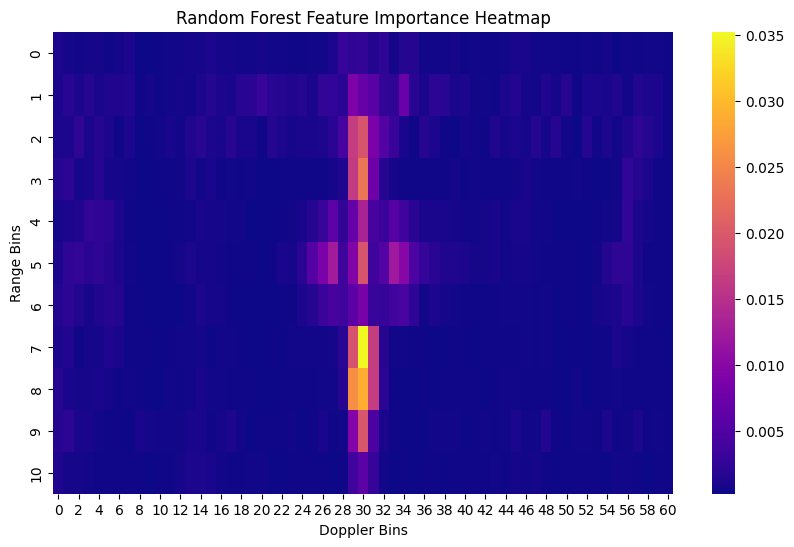

In [6]:
# Feature importances and reshape back to (11, 61)
importances = rf.feature_importances_
importances_reshaped = importances.reshape(11, 61)

# Plot the feature importance heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(importances_reshaped, cmap='plasma')
plt.title("Random Forest Feature Importance Heatmap")
plt.xlabel("Doppler Bins")
plt.ylabel("Range Bins")
plt.show()



# Randomly generate and predict 10 samples and percentage confidence of the prediction

## Accuracy (>91%)

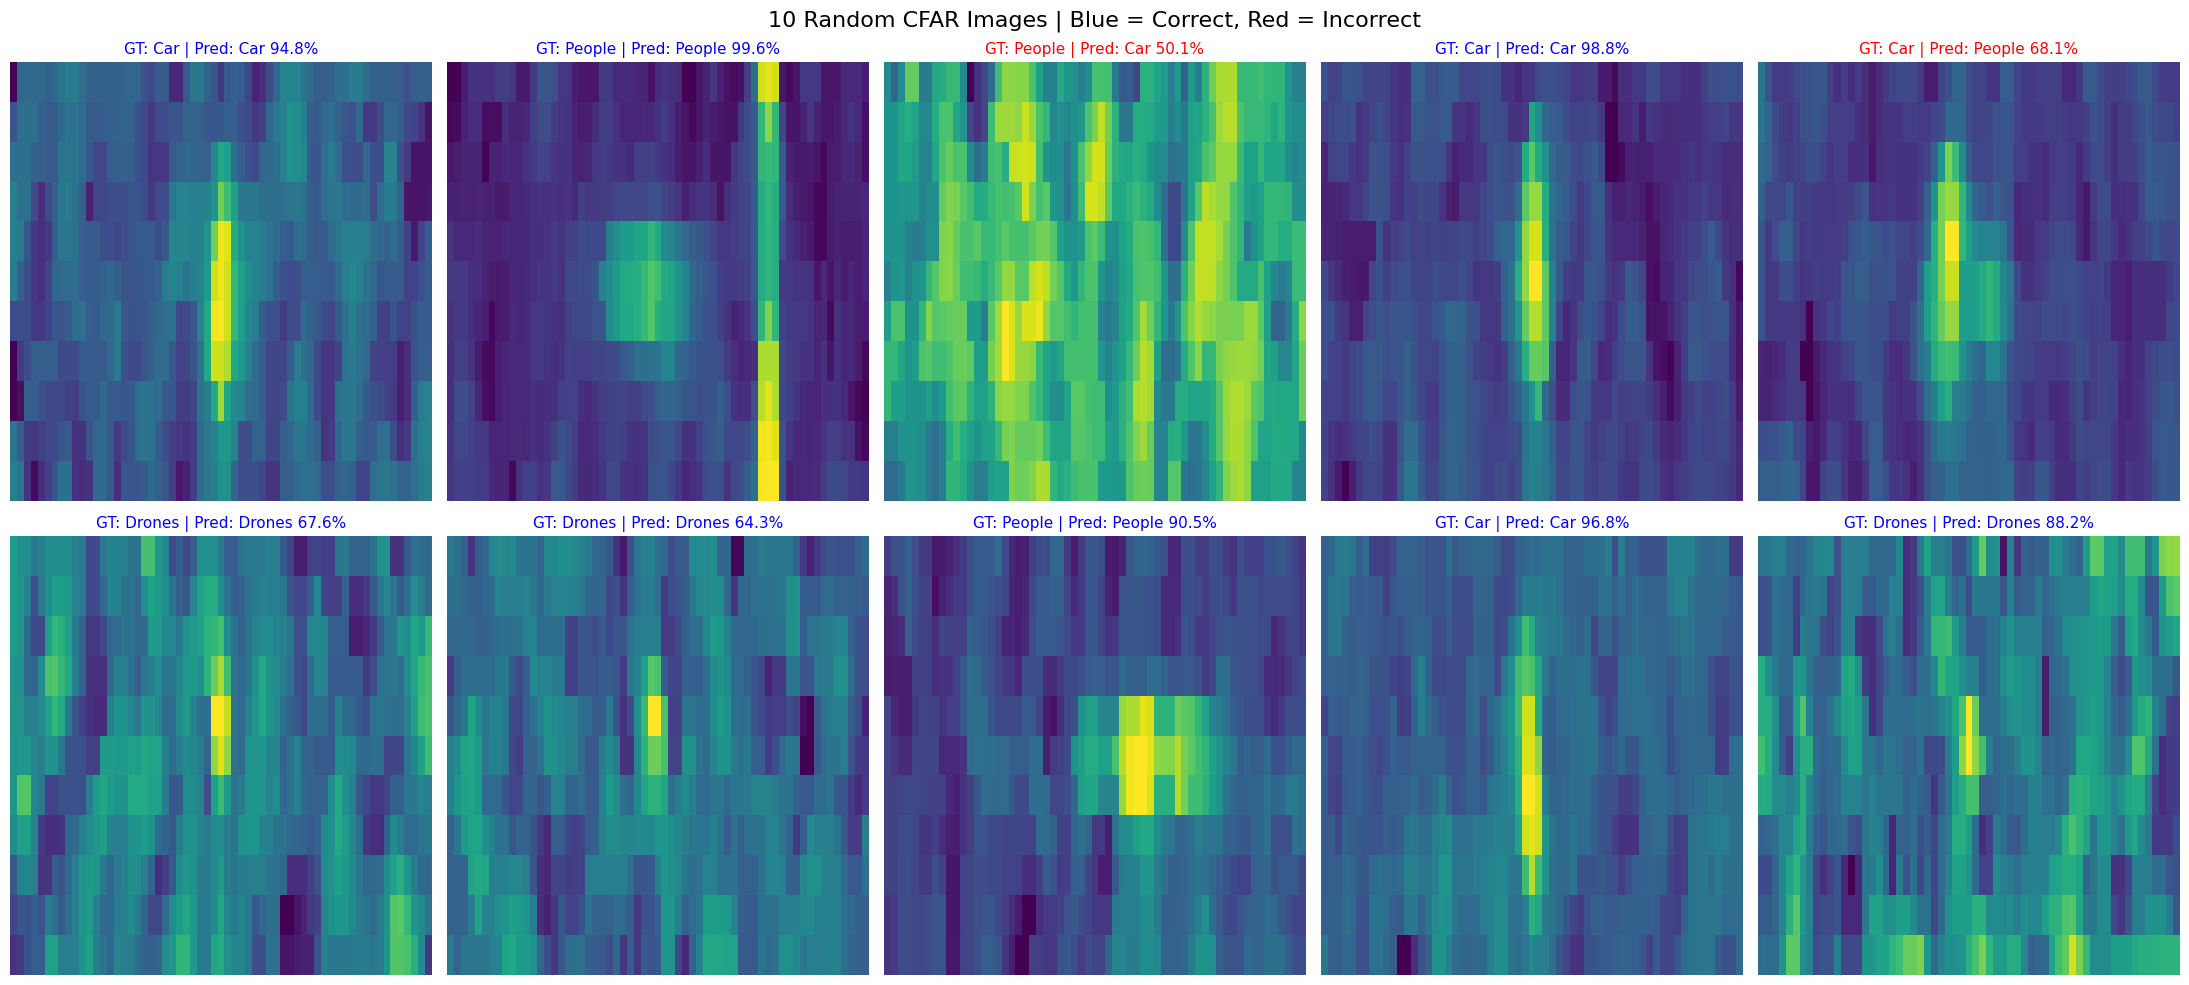

In [7]:
import matplotlib.pyplot as plt
import random

# Label map
label_map = {0: 'Car', 1: 'Drones', 2: 'People'}

# Randomly select 10 samples
random_indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(22, 10))

for i, idx in enumerate(random_indices):
    flat_sample = X_test[idx]
    true_label = y_test[idx]
    matrix_2D = flat_sample.reshape(11, 61)
    
    # Predict
    probs = rf.predict_proba([flat_sample])[0]
    predicted_label = np.argmax(probs)
    predicted_prob = probs[predicted_label] * 100  # %

    # Title color logic
    title_color = 'blue' if predicted_label == true_label else 'red'

    # Plot heatmap
    plt.subplot(2, 5, i + 1)
    sns.heatmap(matrix_2D, cmap="viridis", cbar=False)
    plt.axis('off')

    # Title 
    plt.title(
        f"GT: {label_map[true_label]} | Pred: {label_map[predicted_label]} {predicted_prob:.1f}%", 
        color=title_color,
        fontsize=11
    )

plt.suptitle("10 Random CFAR Images | Blue = Correct, Red = Incorrect", fontsize=16)
plt.tight_layout()
plt.show()

